In [13]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import tensorflow as tf

from src import visibility_patches as vp
from src import image_visibility_graph as ivg
from src import tools

# Loading data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
label_descriptions = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

## Exploratory data analysis

- Class visualization

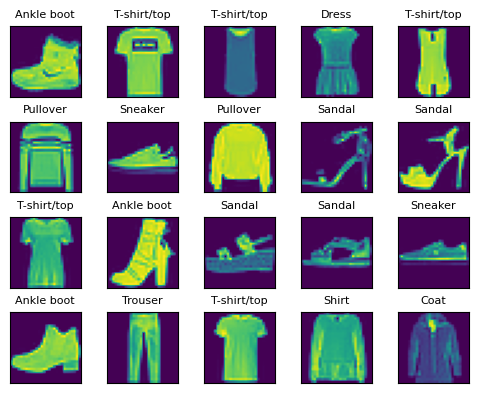

In [9]:
tools.plot_images(
    x_train[:20], 
    [label_descriptions[i] for i in (y_train[:20])], 
    n_cols=5, 
    figsize=(5,4)
)

- Feature visualization

In [15]:
# number of pixels/nodes in the graphs 
N=x_train[0].shape[0] ** 2

# Get a sample
Iseq = [x_train[0], x_train[5], x_train[2], x_train[3], x_train[19]]

Pk = []
Z = []

# Set a maximum degree
maxK = 100

for img in Iseq:
    G = ivg.image_visibility_graph(img, 'horizontal', False)

    # Calculate the degree sequence
    Deg_seq = np.array(list(dict(G.degree()).values()))

    # Degree distribution as a global-image-properties descriptor
    Pk.append(np.histogram(Deg_seq, bins=np.arange(1, maxK+2), density=True)[0])

    # Patch frequency as a local-image-properties descriptor
    img = img.reshape((img.shape[0], img.shape[1], 1))
    Z.append(vp.visibility_patches(img, 1, 'horizontal'))

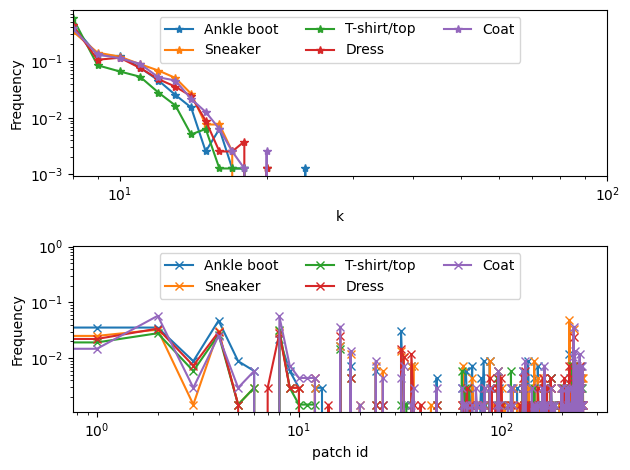

In [66]:
import matplotlib.pyplot as plt

channels = 1

# Set a maximum degree
maxK = 100

# Plot the degree distributions
plt.figure()

plt.subplot(2, 1, 1)
plt.loglog(np.arange(1, maxK + 1), Pk[0], '-*', label='Ankle boot')
plt.loglog(np.arange(1, maxK + 1), Pk[1], '-*', label='Sneaker')
plt.loglog(np.arange(1, maxK + 1), Pk[2], '-*', label='T-shirt/top')
plt.loglog(np.arange(1, maxK + 1), Pk[3], '-*', label='Dress')
plt.loglog(np.arange(1, maxK + 1), Pk[4], '-*', label='Coat')
plt.xlim(8, maxK)
plt.xlabel('k')
plt.ylabel('Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3)

# Plot the visibility patches
plt.subplot(2, 1, 2)
for i, label in enumerate(['Ankle boot', 'Sneaker', 'T-shirt/top', 'Dress', 'Coat']):
    for j in range(channels):
        plt.loglog(Z[i][j], '-x', label=label if j == 0 else None)

plt.xlabel('patch id')
plt.ylabel('Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3)

plt.tight_layout()
plt.show()

# Data processing

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, f1_score
import seaborn as sns
import multiprocessing
from functools import partial

- Get sample with 2000 images for training and 500 for testing

In [19]:
x_train_balanced = []
y_train_balanced = []
x_test_balanced = []
y_test_balanced = []

n_train_samples = 200
n_test_samples = 50

for i in range(10):
    train_indices = np.where(y_train == i)[0][:n_train_samples]
    x_train_balanced.append(x_train[train_indices])
    y_train_balanced.append(y_train[train_indices])
    
    test_indices = np.where(y_test == i)[0][:n_test_samples]
    x_test_balanced.append(x_test[test_indices])
    y_test_balanced.append(y_test[test_indices])

x_train = np.concatenate(x_train_balanced, axis=0)
y_train = np.concatenate(y_train_balanced, axis=0)
x_test = np.concatenate(x_test_balanced, axis=0)
y_test = np.concatenate(y_test_balanced, axis=0)


In [23]:
%%time
# i.   Apply Horizontal and Vertical graphs to each image
# ii.  Get Degree distribution for each image and type of graph
# iii. Collect Visual Patches for each image
# iv.  Flatten the Degree distribution and also the visual patches to be features of the image

def preprocess_data(img, image_visibility_graph, degree_distribution, visibility_patches):
    G_horizontal = ivg.image_visibility_graph(img, 'horizontal', False)
    G_vertical = ivg.image_visibility_graph(img, 'natural', False)

    degree_horizontal = tools.degree_distribution(G_horizontal, 100)
    degree_horizontal = np.array(degree_horizontal)
    
    degree_vertical = tools.degree_distribution(G_vertical, 100)
    degree_vertical = np.array(degree_vertical)

    img = img.reshape((img.shape[0], img.shape[1], 1))
    patches_horizontal = vp.visibility_patches(img, 1, 'horizontal')
    patches_vertical = vp.visibility_patches(img, 1, 'natural')

    # Flatten the degree distributions and visual patches and concatenate them
    feature_vector = np.concatenate(
        [
            degree_horizontal.flatten(),
            degree_vertical.flatten(),
            patches_horizontal.flatten(),
            patches_vertical.flatten()
        ]
    )
    
    return feature_vector


# Number of processes for parallel processing
N = 4
# Process images using multiprocessing
with multiprocessing.Pool(N) as pool:
    process_func = partial(
        preprocess_data, 
        image_visibility_graph=ivg.image_visibility_graph, 
        degree_distribution=tools.degree_distribution, 
        visibility_patches=vp.visibility_patches
    )
    x_train_features = pool.map(process_func, x_train)
    x_test_features = pool.map(process_func, x_test)


CPU times: user 194 ms, sys: 69.5 ms, total: 264 ms
Wall time: 2min 12s


In [24]:
x_train_features = np.array(x_train_features)
x_test_features = np.array(x_test_features)

In [25]:
%%time
# Normalize train and test data
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_features)
x_test_norm = scaler.transform(x_test_features)

# Apply PCA for dimensionality reduction to dim D
D = 100
pca = PCA(n_components=D)
x_train_pca = pca.fit_transform(x_train_norm)
x_test_pca = pca.transform(x_test_norm)

CPU times: user 2.83 s, sys: 541 ms, total: 3.37 s
Wall time: 2.35 s


# Supervised learning

In [ ]:
# Apply SVM with a quadratic kernel
svm = SVC(kernel='poly', degree=2)
svm.fit(x_train_pca, y_train)
y_pred_svm = svm.predict(x_test_pca)

# Apply RF
rf = RandomForestClassifier()
rf.fit(x_train_pca, y_train)
y_pred_rf = rf.predict(x_test_pca)

## Evaluation

In [26]:
print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        50
           1       0.90      0.90      0.90        50
           2       0.62      0.60      0.61        50
           3       0.56      0.84      0.67        50
           4       0.52      0.54      0.53        50
           5       0.91      0.78      0.84        50
           6       0.55      0.34      0.42        50
           7       0.81      0.88      0.85        50
           8       0.85      0.68      0.76        50
           9       0.82      0.80      0.81        50

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.71       500
weighted avg       0.72      0.72      0.71       500



In [27]:
print("RF Classification Report")
print(classification_report(y_test, y_pred_rf))

RF Classification Report
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        50
           1       0.87      0.94      0.90        50
           2       0.54      0.52      0.53        50
           3       0.67      0.80      0.73        50
           4       0.42      0.54      0.47        50
           5       0.93      0.76      0.84        50
           6       0.63      0.24      0.35        50
           7       0.85      0.90      0.87        50
           8       0.85      0.82      0.84        50
           9       0.77      0.88      0.82        50

    accuracy                           0.71       500
   macro avg       0.72      0.71      0.70       500
weighted avg       0.72      0.71      0.70       500



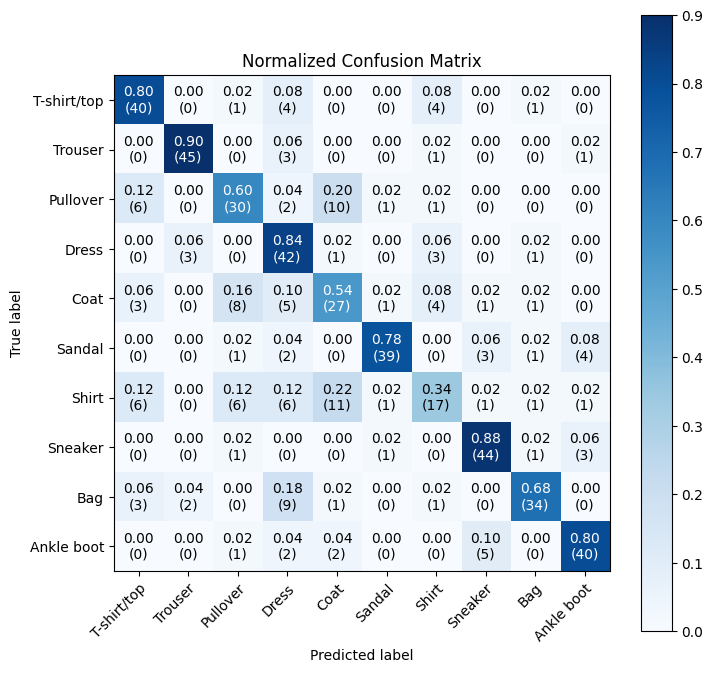

In [28]:
tools.plot_confusion_matrix(y_pred_svm, y_test, label_descriptions)

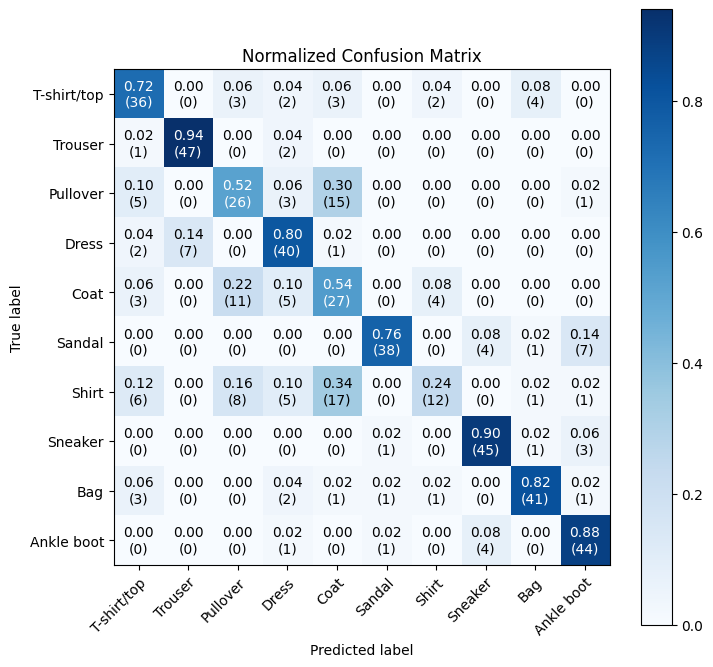

In [29]:
tools.plot_confusion_matrix(y_pred_rf, y_test, label_descriptions)

# Unsupervised learning

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.cm as cm

## Kmeans

- Silhouette analysis
- Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [33]:
X = x_train_pca

For n_clusters = 2 The average silhouette_score is : 0.12371944099616823
For n_clusters = 3 The average silhouette_score is : 0.09850242751243261
For n_clusters = 4 The average silhouette_score is : 0.10071191161442791
For n_clusters = 5 The average silhouette_score is : 0.0961856226966704
For n_clusters = 6 The average silhouette_score is : 0.08424933959784234
For n_clusters = 7 The average silhouette_score is : 0.07846595018287353
For n_clusters = 8 The average silhouette_score is : 0.0840958735266205
For n_clusters = 9 The average silhouette_score is : 0.0839569788953546
For n_clusters = 10 The average silhouette_score is : 0.06995052665067789


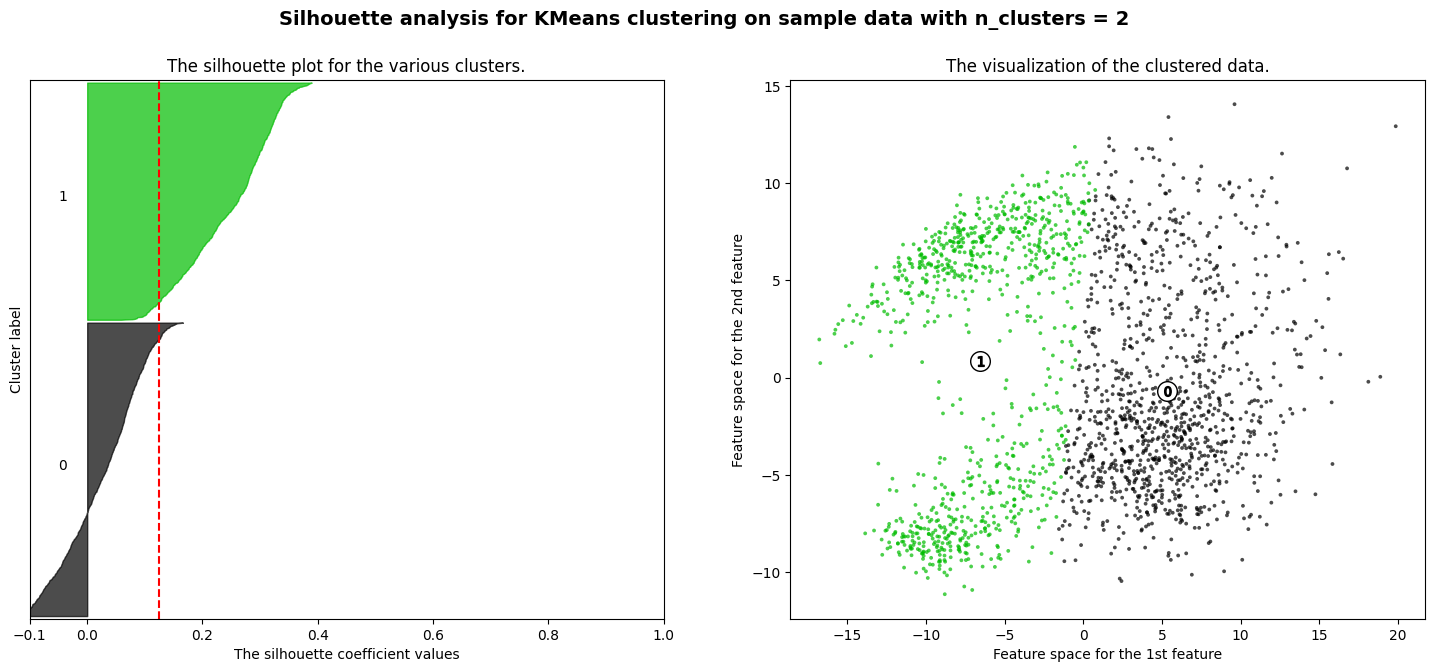

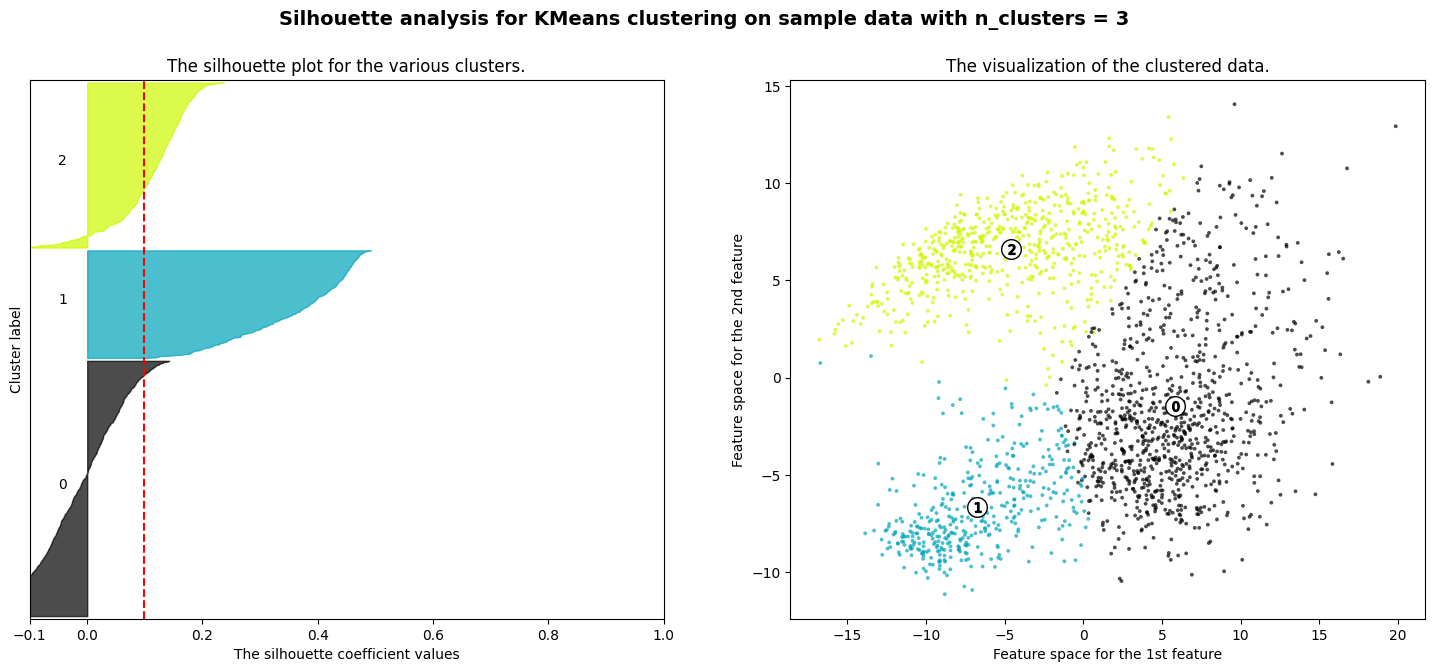

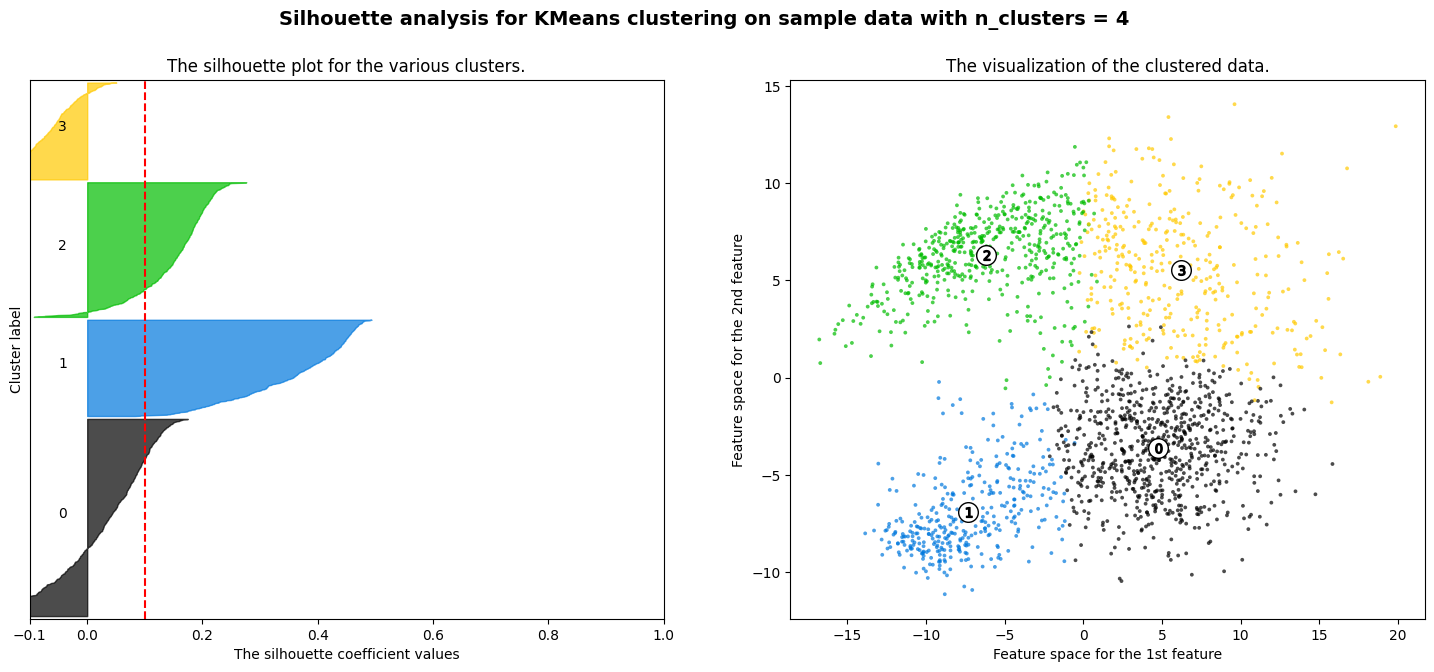

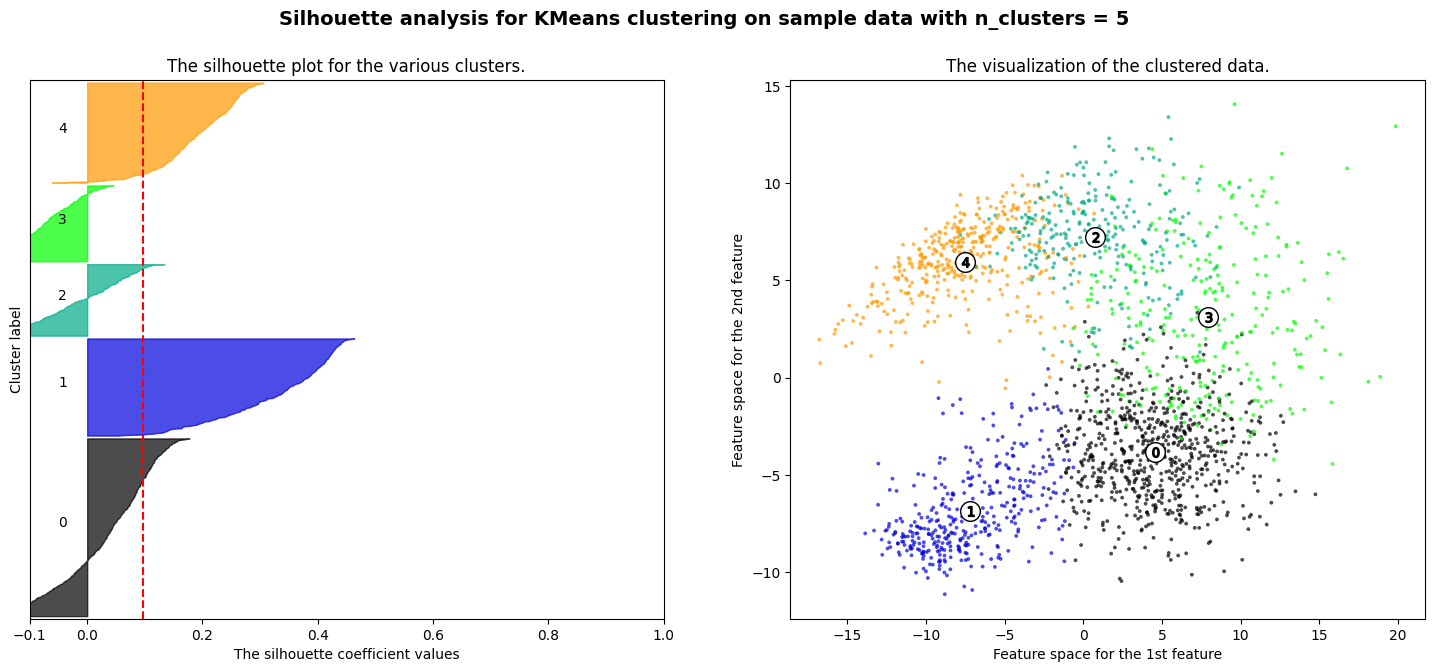

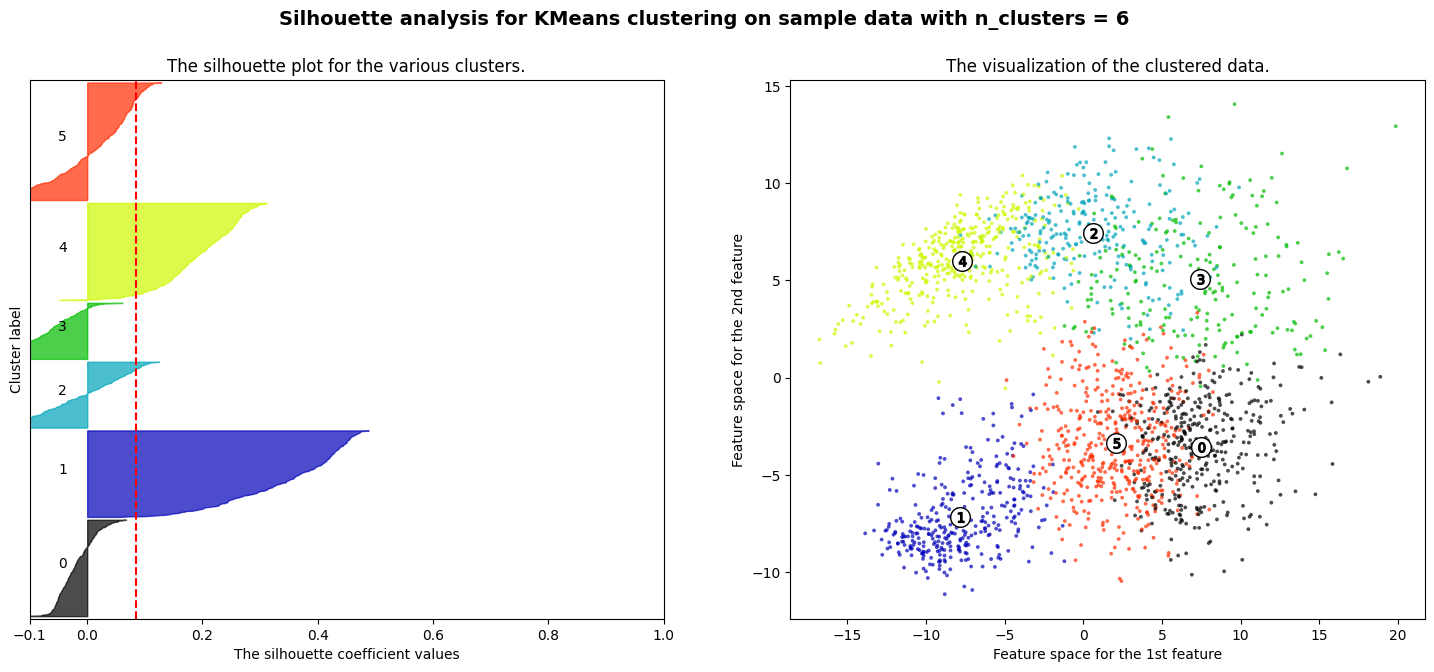

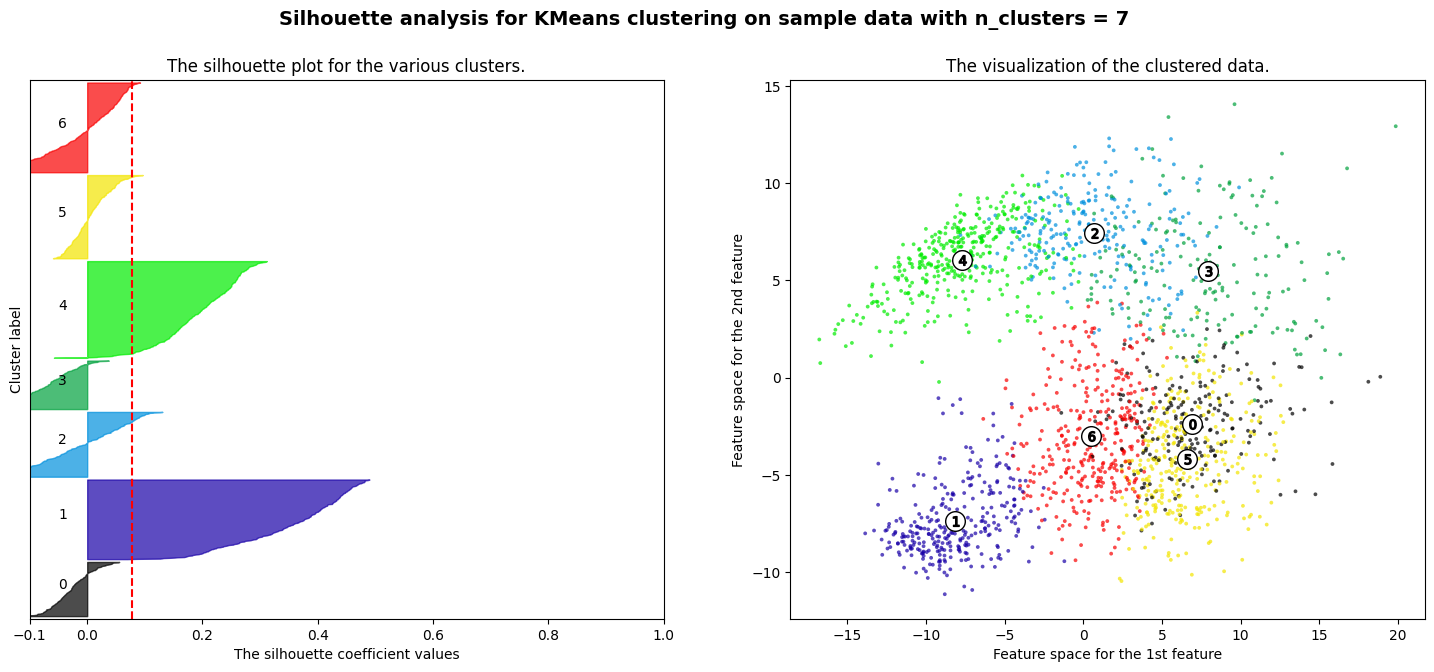

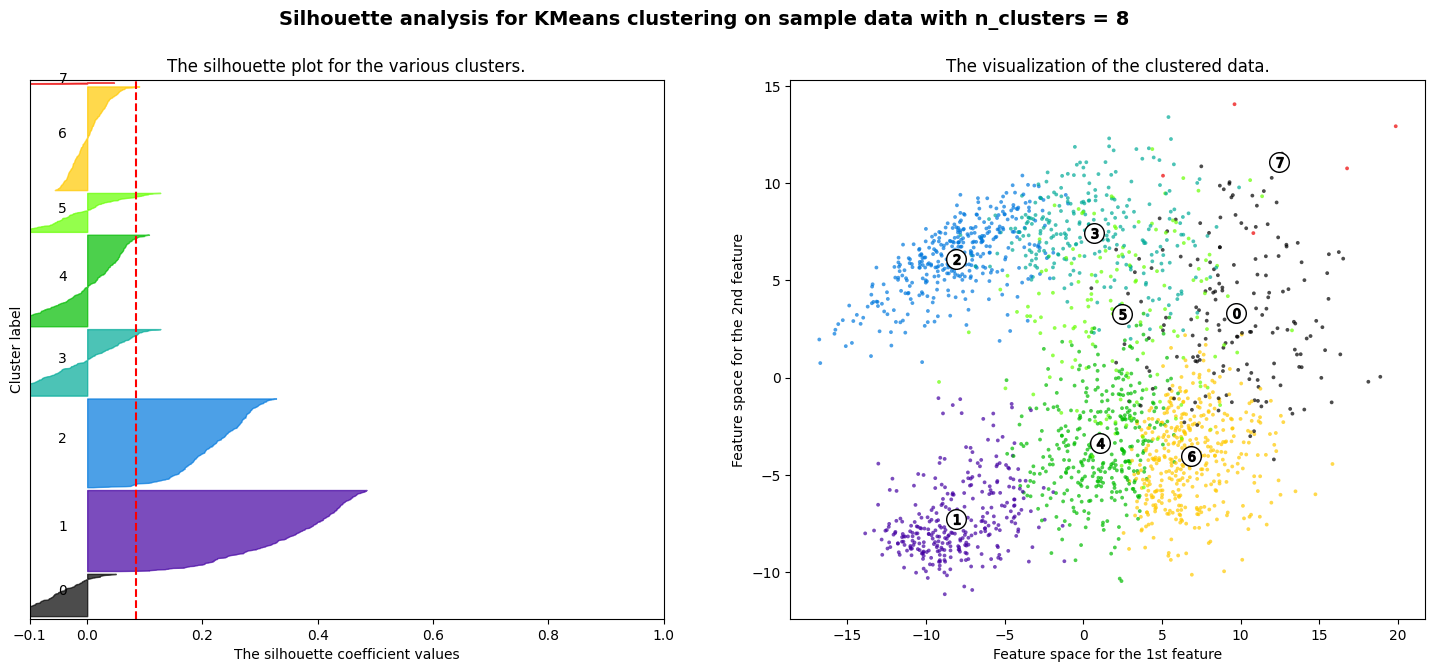

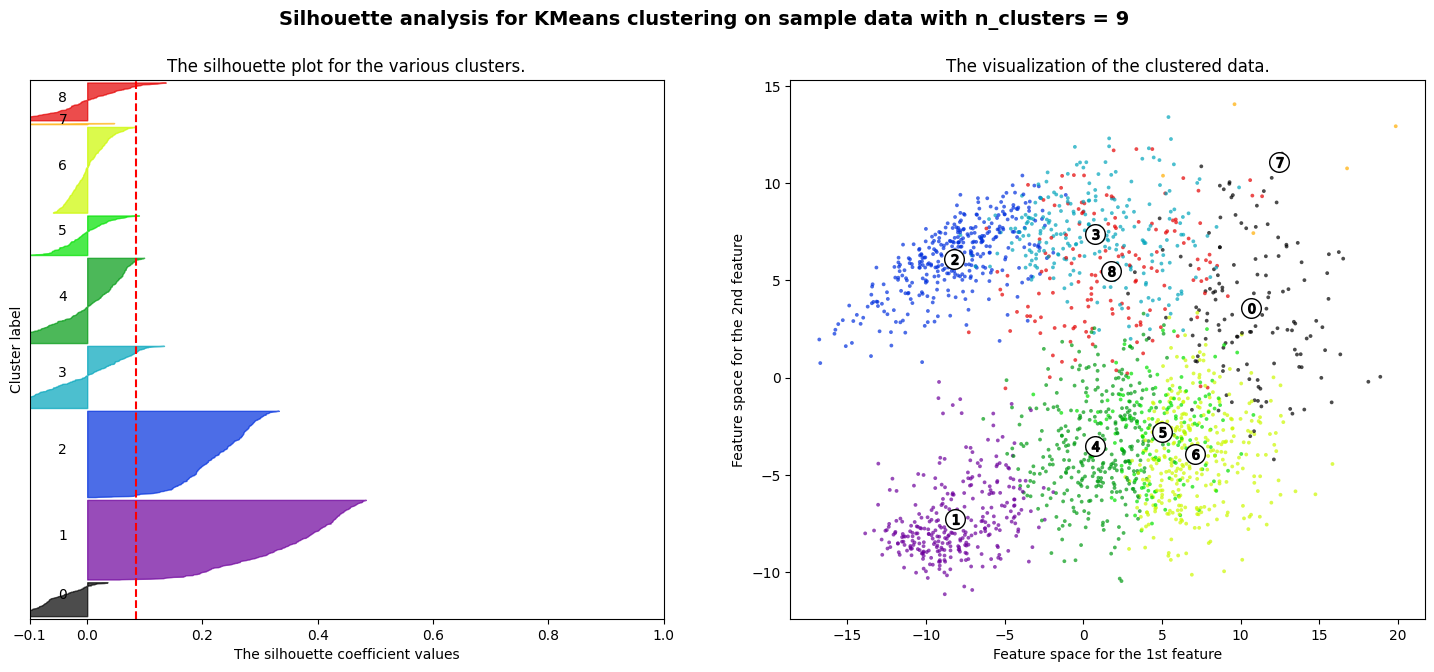

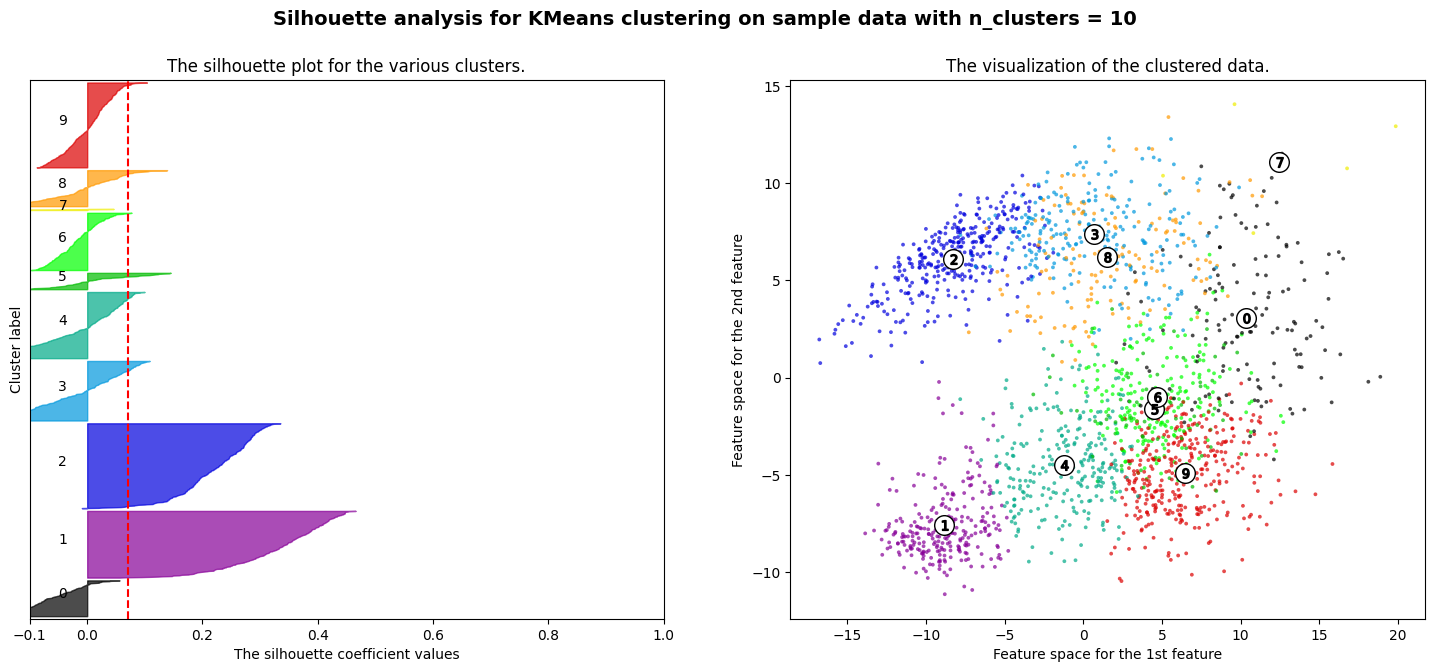

In [76]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

- Elbow curve

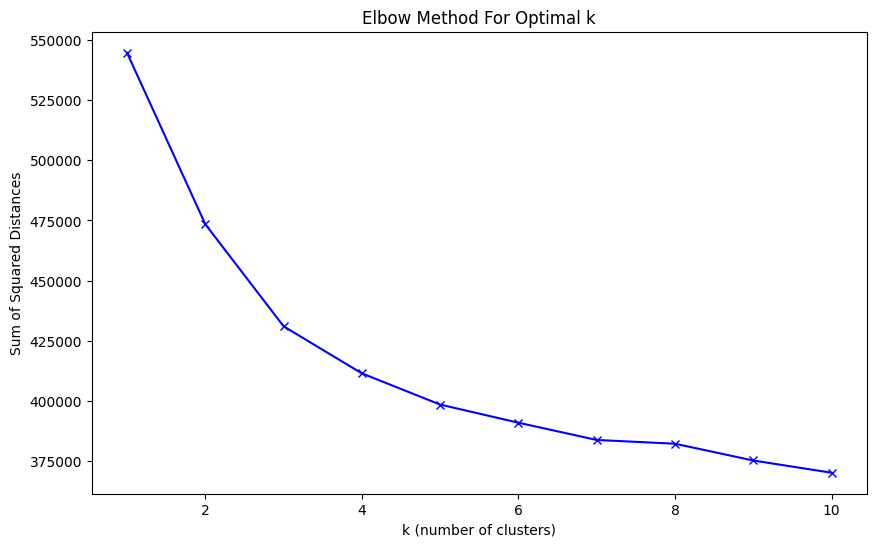

In [35]:
ssd = []

K = range(1,11)

for k in K:
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(X)
    ssd.append(km.inertia_) 

plt.figure(figsize=(10,6))
plt.plot(K, ssd, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [36]:
k = 2

In [37]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans.fit(x_train_pca)

KMeans(n_clusters=2, n_init='auto', random_state=42)

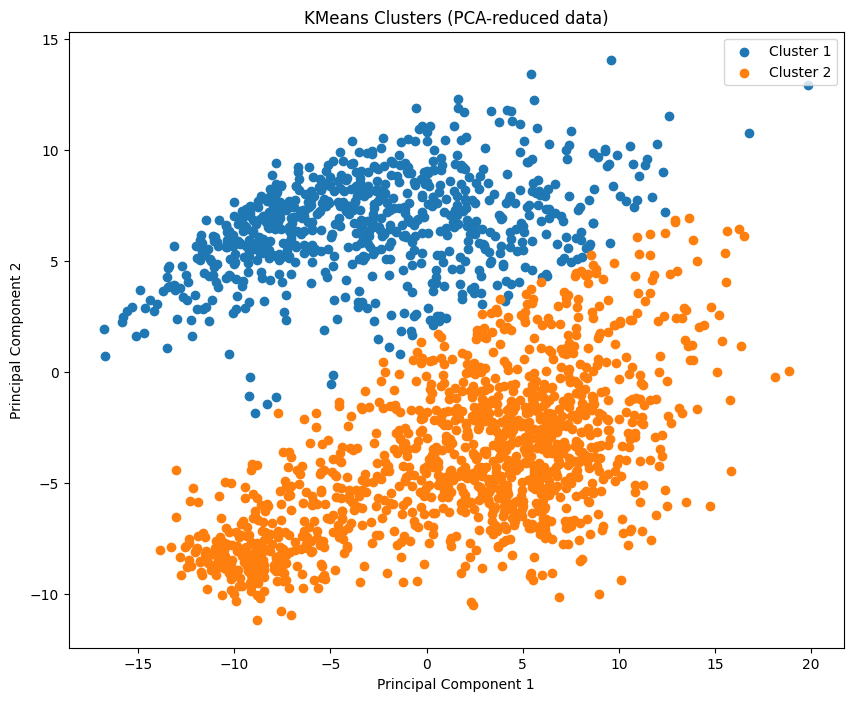

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
x_train_pca_2d = pca.fit_transform(x_train_pca)

predicted_clusters = kmeans.predict(x_train_pca)

plt.figure(figsize=(10, 8))

for i in range(k):
    plt.scatter(x_train_pca_2d[predicted_clusters == i, 0], 
                x_train_pca_2d[predicted_clusters == i, 1],
                label=f'Cluster {i+1}')

plt.title('KMeans Clusters (PCA-reduced data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [39]:
df_clusters = pd.DataFrame({'label':pd.Series(y_train).map(label_descriptions), 'cluster':kmeans.labels_})

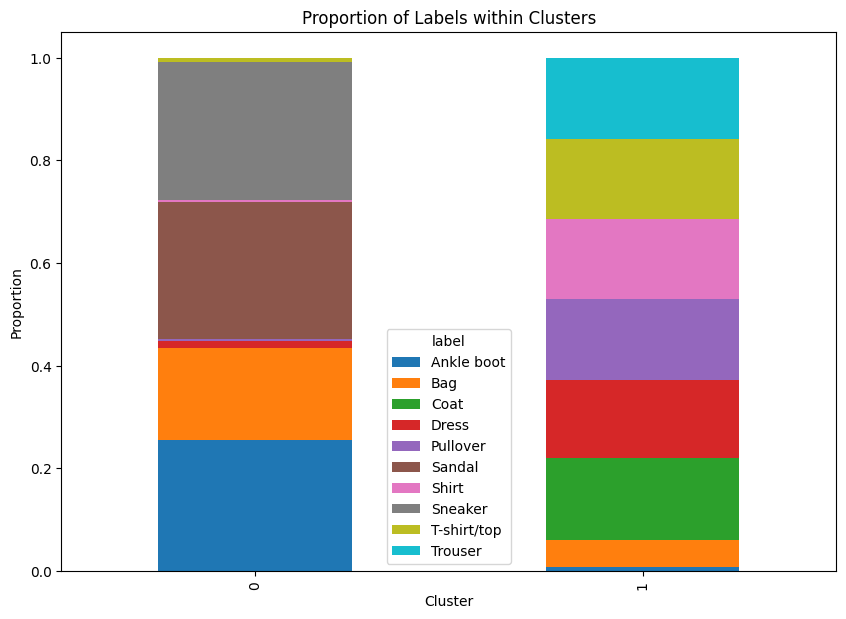

In [43]:
df_grouped = df_clusters.groupby(['cluster', 'label']).size().unstack()

df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)

df_grouped.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Proportion of Labels within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

## Louvain

In [50]:
from community import community_louvain

In [51]:
M_corr = np.corrcoef(x_train_pca)

In [52]:
M_adj = abs(np.multiply(M_corr, (M_corr > 0).astype(int)))

<Axes: >

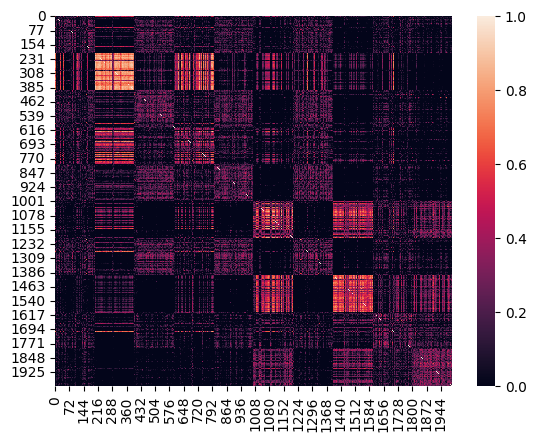

In [127]:
sns.heatmap(M_adj)

In [53]:
np.fill_diagonal(M_adj, 0)
correlation_matrix = np.tril(M_adj)
G = nx.from_numpy_array(correlation_matrix)

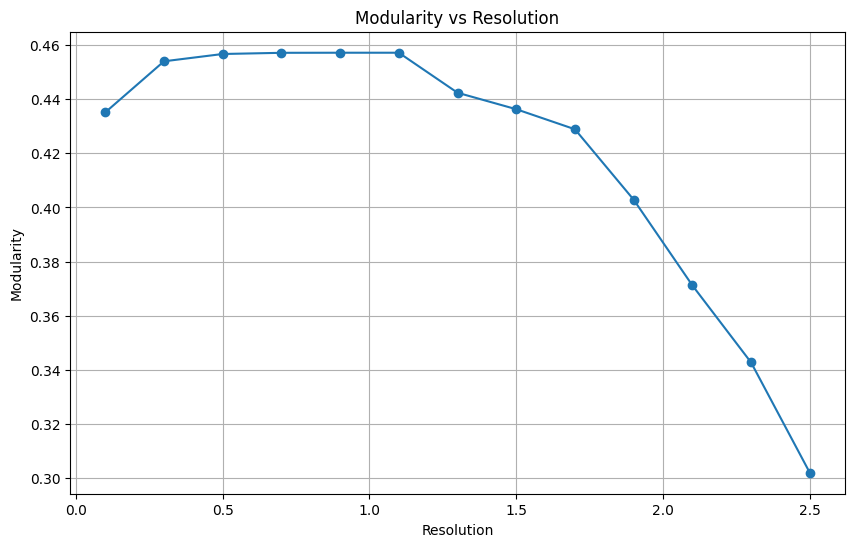

In [165]:
resolution_values = np.arange(0.1, 2.6, 0.2)

modularity_values = []

for resolution in resolution_values:
    partition = community_louvain.best_partition(G, resolution=resolution)
    modularity = community_louvain.modularity(partition, G)
    modularity_values.append(modularity)

plt.figure(figsize=(10, 6))
plt.plot(resolution_values, modularity_values, marker='o')
plt.title('Modularity vs Resolution')
plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.grid(True)
plt.show()

In [54]:
partition = community_louvain.best_partition(G, resolution=0.5)
print(np.unique(np.array((list(partition.values())))))
modularity = community_louvain.modularity(partition, G)
print("Modularity of the partition:", modularity)

[0 1 2]
Modularity of the partition: 0.4571016014987278


In [55]:
import matplotlib.patches as mpatches
def visualize_network(G, partition, title, k=0.4):
    plt.figure(figsize=(14, 10))
    pagerank = nx.pagerank(G)

    cmap = plt.cm.get_cmap('viridis', len(set(partition.values())))
    colors = [cmap(partition[node]) for node in G.nodes]

    pos = nx.spring_layout(G, seed=42, k=k)

    nx.draw_networkx_nodes(
        G, pos, node_color=colors, node_size=[v * 9000 for v in pagerank.values()], alpha=0.8
    )

    nx.draw_networkx_edges(G, pos, alpha=0.001)
    communities = sorted(set(partition.values()))
    handles = [mpatches.Patch(color=cmap(community / len(communities)), label=f"Community {community}") for community in communities]
    plt.legend(handles=handles, loc='upper right')

    plt.title(title)
    plt.show()

/tmp/ipykernel_182362/2210291831.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(set(partition.values())))


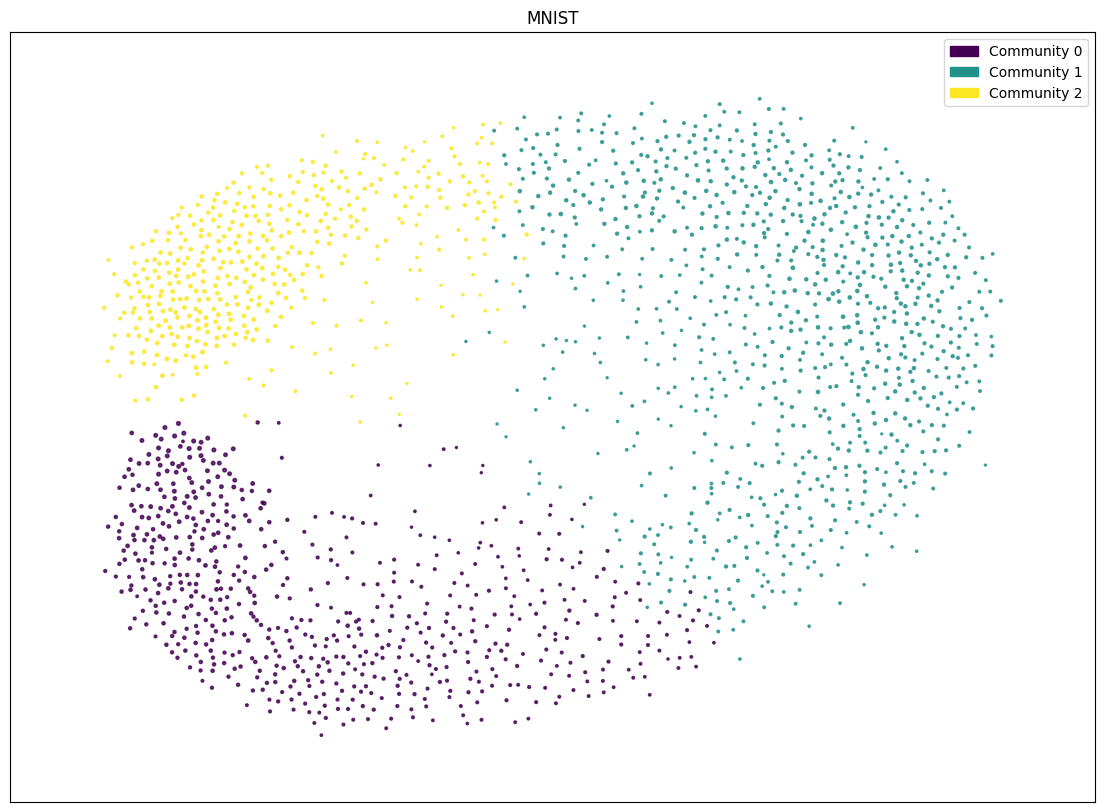

In [171]:
visualize_network(G, partition, "MNIST")

In [56]:
df_partitions = pd.DataFrame({'label':pd.Series(y_train).map(label_descriptions), 'cluster':partition.values()})

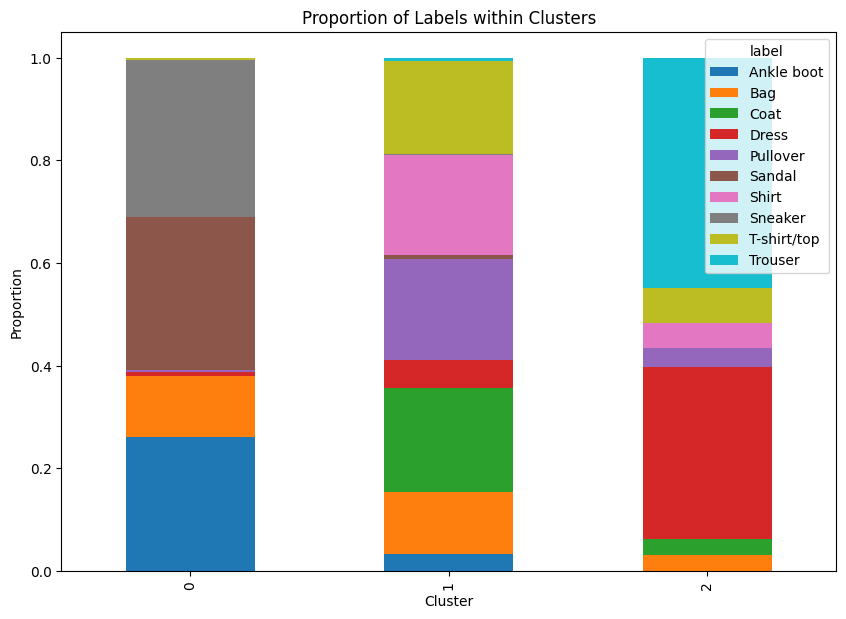

In [58]:
df_grouped = df_partitions.groupby(['cluster', 'label']).size().unstack()
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)

df_grouped.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Proportion of Labels within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

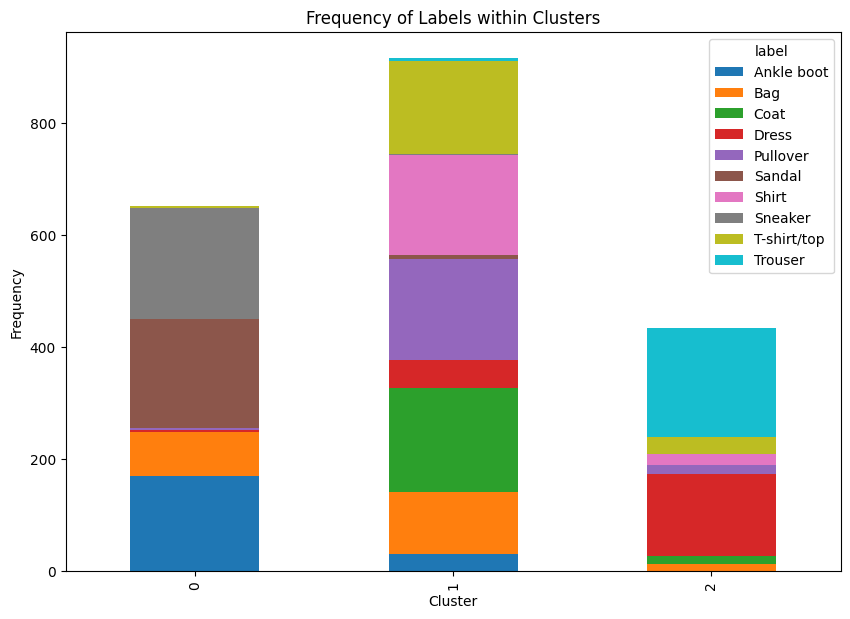

In [59]:
df_grouped = df_partitions.groupby(['cluster', 'label']).size().unstack()

df_grouped.plot(kind='bar', stacked=True, figsize=(10,7))
plt.title('Frequency of Labels within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

In [60]:
cluster = 1
idx = [i for i,j in partition.items() if j == cluster]

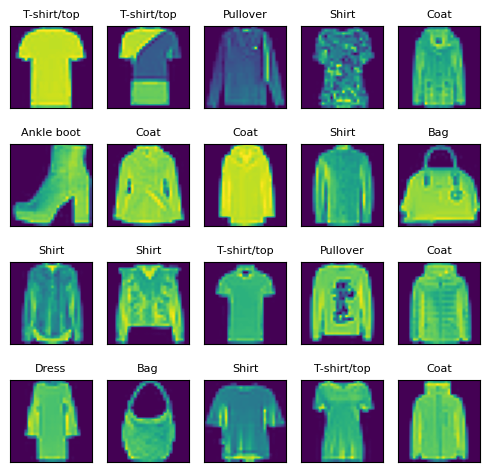

In [62]:
idx_rand = np.random.choice(idx, 20)
tools.plot_images(
    x_train[idx_rand], 
    [label_descriptions[i] for i in (y_train[idx_rand])], n_cols=5, figsize=(5,5)
)